ECE1786 2024 Fall - Team GPT4PT Final Project

Author:

Hongliang Zhu, Zijun Chen, Feiting Yang, Tom Blanchard

# Data Collection
Scraping new data from mbti forums using Selenium library

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import csv
import time
import traceback

def scrape_posts_to_csv(urls, csv_filename='posts.csv'):
    PAGE_MAX = 15

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

    try:
        with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['type', 'posts'])

            for type,url in urls:
                driver.get(url)
                wait = WebDriverWait(driver, 10)
                page_count = 0
                while True:
                    # Scrape post data on the current page
                    post_contents = wait.until(
                        EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.message-userContent'))
                    )

                    for content in post_contents:
                        text = content.text.strip()
                        writer.writerow([type, text])

                    if page_count >= PAGE_MAX:
                        break

                    try:
                        next_button = wait.until(
                            EC.element_to_be_clickable((By.CSS_SELECTOR, '.pageNav-jump--next'))
                        )
                        next_href = next_button.get_attribute('href')
                        if next_href:
                            driver.get(next_href)
                            time.sleep(2)
                            page_count += 1
                        else:
                            break
                    except Exception as e:
                        print("No more pages or an unexpected error occurred:", e)
                        break

    except Exception as e:
        print(f'An error occurred: {e}')
        traceback.print_exc()
    finally:
        driver.quit()

In [ ]:
urls = [
    ('ESTJ','https://www.personalitycafe.com/threads/ask-an-estj.489586/'),
    ('INFP', 'https://www.personalitycafe.com/threads/stream-of-consciousness-vent-thread.6141/'),
]
scrape_posts_to_csv(urls, 'collected_posts.csv')

No more pages or an unexpected error occurred: Message: 



# Data Pre-processing
Preprocess the data, analyzing, cleaning and tokenzing.

In [ ]:
pip install datasets

In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from datasets import Dataset
import torch
from sklearn.preprocessing import LabelEncoder

In [3]:
# Loading the extracted CSV file
csv_path = 'mbti_1.csv'
df = pd.read_csv(csv_path, engine='python')

# Displaying the first few rows to understand its structure
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## Split the MBTI type to subcategory

In [9]:
df['I/E'] = df['type'].apply(lambda x: 'I' if 'I' in x else 'E')
df['N/S'] = df['type'].apply(lambda x: 'N' if 'N' in x else 'S')
df['T/F'] = df['type'].apply(lambda x: 'T' if 'T' in x else 'F')
df['J/P'] = df['type'].apply(lambda x: 'J' if 'J' in x else 'P')

## Data cleaning

In [10]:
#check the missing value
df.isnull().sum()

,0
type,0
posts,0
I/E,0
N/S,0
T/F,0
J/P,0


In [11]:
# Remove URLs and "|||" from the 'posts' column
df['posts'] = df['posts'].apply(lambda x: re.sub(r'http\S+|www.\S+|\|\|\|', '', x))

In [8]:
# remove punctuation
import string
string.punctuation
def puntucation_free(text):
    output=''.join([i for i in text if i not in string.punctuation])
    return output
df['posts']=df['posts'].apply(lambda x:puntucation_free(x))

In [13]:
#Lower Text
df['posts']=df['posts'].apply(lambda x:x.lower())

In [4]:
# Tokenization
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
df['posts']=df['posts'].apply(lambda x:word_tokenize(x))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fulma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Fulma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
#remove stopwords
import nltk
nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    output=[i for i in text if i not in stopwords]
    return output
df['posts']=df['posts'].apply(lambda x:remove_stopwords(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fulma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# stemming
from nltk.stem.porter import PorterStemmer
porter_stemmer=PorterStemmer()
def stemming(text):
    output=[porter_stemmer.stem(i) for i in text]
    return output
df['posts']=df['posts'].apply(lambda x:stemming(x))

In [22]:
df['posts'] = df['posts'].str.join(' ')

In [23]:
df.head(3)

,type,posts,I/E,N/S,T/F,J/P
0,INFJ,intj moment sportscent top ten play prankswhat...,I,N,F,J
1,ENTP,im find lack post alarmingsex bore posit often...,E,N,T,P
2,INTP,good one cours say know that bless cursedo abs...,I,N,T,P


## EDA

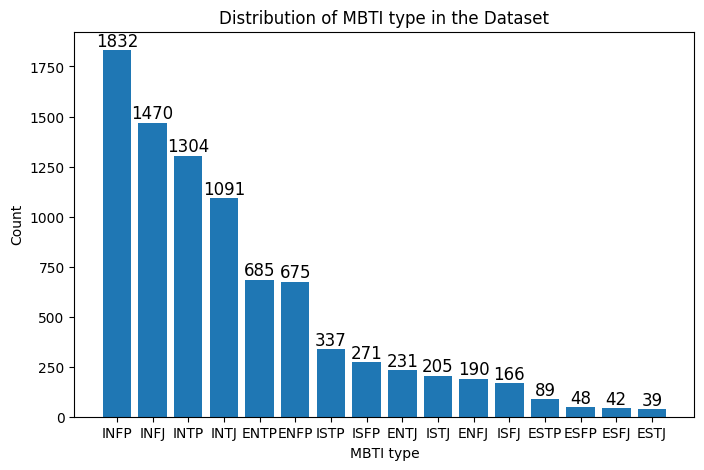

In [ ]:
import matplotlib.pyplot as plt

# Calculate the distribution of each category ('I' and 'E')
category_counts = df['type'].value_counts()

# Plotting the distribution as a bar chart
plt.figure(figsize=(8, 5))
#plt.bar(category_counts.index, category_counts.values)
bars = plt.bar(category_counts.index, category_counts.values)

# Adding values on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()),
             ha='center', va='bottom', fontsize=12)
plt.xlabel('MBTI type')
plt.ylabel('Count')
plt.title('Distribution of MBTI type in the Dataset')
plt.show()


I/E

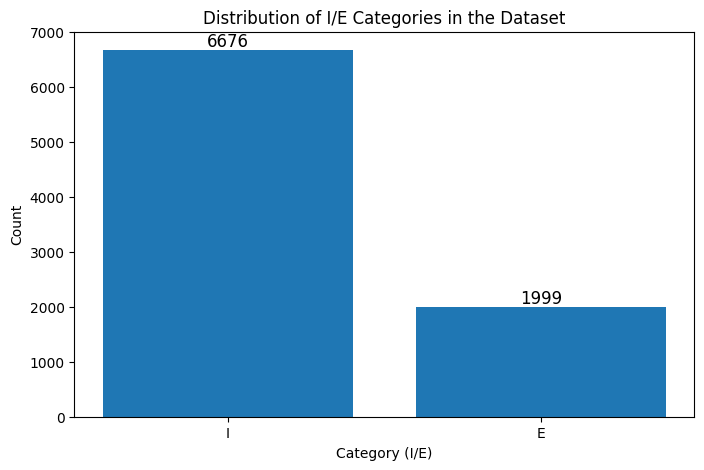

In [ ]:
# Calculate the distribution of each category ('I' and 'E')
category_counts = df['I/E'].value_counts()

# Plotting the distribution as a bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(category_counts.index, category_counts.values)

# Adding values on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()),
             ha='center', va='bottom', fontsize=12)
plt.xlabel('Category (I/E)')
plt.ylabel('Count')
plt.title('Distribution of I/E Categories in the Dataset')
plt.show()

S/N

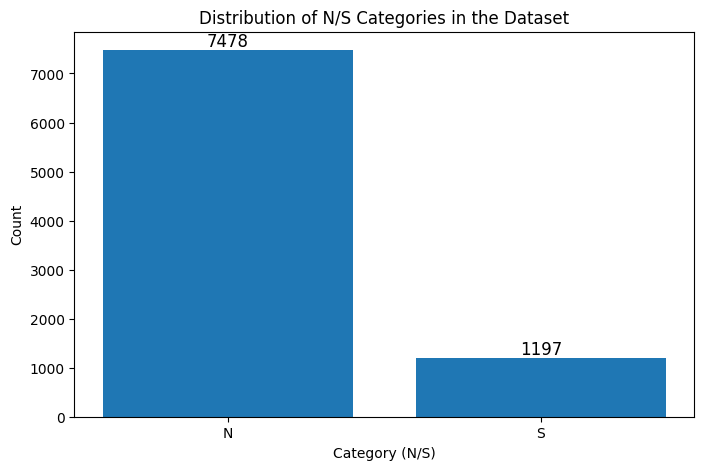

In [ ]:
# Calculate the distribution of each category ('N' and 'S')
category_counts = df['N/S'].value_counts()

# Plotting the distribution as a bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(category_counts.index, category_counts.values)

# Adding values on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()),
             ha='center', va='bottom', fontsize=12)
plt.xlabel('Category (N/S)')
plt.ylabel('Count')
plt.title('Distribution of N/S Categories in the Dataset')
plt.show()

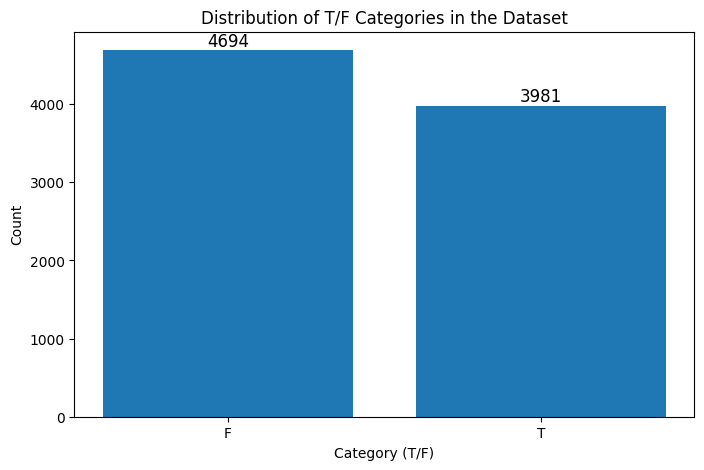

In [ ]:
# Calculate the distribution of each category ('N' and 'S')
category_counts = df['T/F'].value_counts()

# Plotting the distribution as a bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(category_counts.index, category_counts.values)

# Adding values on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()),
             ha='center', va='bottom', fontsize=12)
plt.xlabel('Category (T/F)')
plt.ylabel('Count')
plt.title('Distribution of T/F Categories in the Dataset')
plt.show()

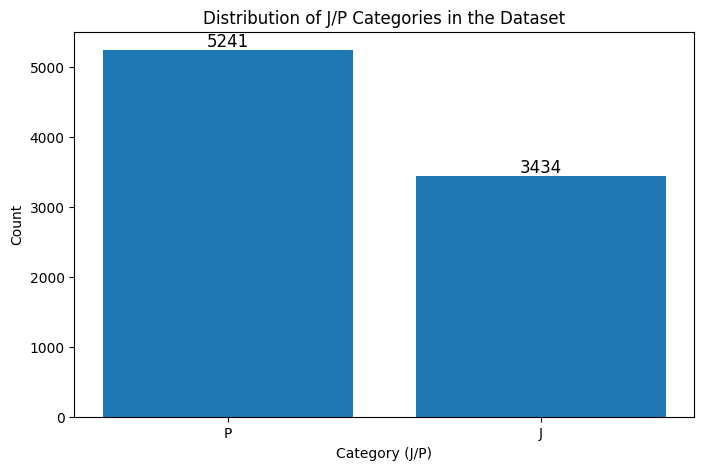

In [ ]:
# Calculate the distribution of each category ('J' and 'P')
category_counts = df['J/P'].value_counts()

# Plotting the distribution as a bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(category_counts.index, category_counts.values)

# Adding values on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()),
             ha='center', va='bottom', fontsize=12)
plt.xlabel('Category (J/P)')
plt.ylabel('Count')
plt.title('Distribution of J/P Categories in the Dataset')
plt.show()

## Label encoding(I:1,E:0)(N:0,S:1)(F:0,T:1)(J:0,P:1)

In [24]:
le = LabelEncoder()
df['I/E'] = le.fit_transform(df['I/E'])
df['N/S'] = le.fit_transform(df['N/S'])
df['T/F'] = le.fit_transform(df['T/F'])
df['J/P'] = le.fit_transform(df['J/P'])

In [25]:
df.head()

,type,posts,I/E,N/S,T/F,J/P
0,INFJ,intj moment sportscent top ten play prankswhat...,1,0,0,0
1,ENTP,im find lack post alarmingsex bore posit often...,0,0,1,1
2,INTP,good one cours say know that bless cursedo abs...,1,0,1,1
3,INTJ,dear intp enjoy convers day esoter gab natur u...,1,0,1,0
4,ENTJ,your firedthat anoth silli misconcept approach...,0,0,1,0


In [90]:
df.to_csv('/content/mbti_data.csv', index=False)

### Subclassifier I/E

In [26]:
# Train-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['posts'], df['I/E'], test_size=0.2, stratify=df['I/E'], random_state=42
)

In [27]:
# Tokenize the texts
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(texts):
    texts_list = texts.tolist()
    return tokenizer(texts_list, truncation=True, padding=True, max_length=100)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [158]:
# Convert to PyTorch datasets
class MBTIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [86]:
train_dataset = MBTIDataset(train_encodings, train_labels)
val_dataset = MBTIDataset(val_encodings, val_labels)

### Subclassifier N/S

In [80]:
# Train-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['posts'], df['N/S'], test_size=0.2, stratify=df['N/S'], random_state=42
)
# Tokenize the texts
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
# Convert to PyTorch datasets
train_dataset = MBTIDataset(train_encodings, train_labels)
val_dataset = MBTIDataset(val_encodings, val_labels)

### Subclassifier T/F

In [81]:
# Train-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['posts'], df['T/F'], test_size=0.2, stratify=df['T/F'], random_state=42
)
# Tokenize the texts
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
# Convert to PyTorch datasets
train_dataset = MBTIDataset(train_encodings, train_labels)
val_dataset = MBTIDataset(val_encodings, val_labels)

### Subclassifier P/J

In [85]:
# Train-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['posts'], df['J/P'], test_size=0.2, stratify=df['J/P'], random_state=42
)
# Tokenize the texts
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
# Convert to PyTorch datasets
train_dataset = MBTIDataset(train_encodings, train_labels)
val_dataset = MBTIDataset(val_encodings, val_labels)

## Test Set
Repeat the above pre-processing steps to create test set using newly collected data

In [77]:
csv_test_path = '/content/collected_posts_cleaned.csv'
df_test = pd.read_csv(csv_test_path)
df_test['I/E'] = df_test['type'].apply(lambda x: 'I' if 'I' in x else 'E')
df_test['N/S'] = df_test['type'].apply(lambda x: 'N' if 'N' in x else 'S')
df_test['T/F'] = df_test['type'].apply(lambda x: 'T' if 'T' in x else 'F')
df_test['J/P'] = df_test['type'].apply(lambda x: 'J' if 'J' in x else 'P')
df_test['posts'] = df_test['posts'].apply(lambda x: re.sub(r'http\S+|www.\S+|\|\|\|', '', x))
df_test['posts']=df_test['posts'].apply(lambda x:puntucation_free(x))
df_test['posts']=df_test['posts'].apply(lambda x:x.lower())
df_test['posts']=df_test['posts'].apply(lambda x:word_tokenize(x))
df_test['posts']=df_test['posts'].apply(lambda x:remove_stopwords(x))
df_test['posts']=df_test['posts'].apply(lambda x:stemming(x))
df_test['posts'] = df_test['posts'].str.join(' ')
df_test['I/E'] = le.fit_transform(df_test['I/E'])
df_test['N/S'] = le.fit_transform(df_test['N/S'])
df_test['T/F'] = le.fit_transform(df_test['T/F'])
df_test['J/P'] = le.fit_transform(df_test['J/P'])
df_test['type_encoding'] = df_test[['I/E', 'N/S', 'T/F', 'J/P']].astype(str).agg(''.join, axis=1)
df_test = df_test.drop(columns=['I/E', 'N/S', 'T/F', 'J/P'])
df_test.head()
test_labels = df_test['type_encoding'].astype(int)
test_encodings = tokenizer(df_test['posts'].tolist(), padding=True,truncation=True,max_length=100)
test_dataset = MBTIDataset(test_encodings, test_labels)

In [79]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
for batch in test_loader:
    print("Batch Input IDs:", batch['input_ids'])
    print("Batch Labels:", batch['labels'])
    break

Batch Input IDs: tensor([[31699,  1842, 36543, 31049,   966,   892,   534,  1333,  4036,  9989,
          1054,    71,   966, 46436,  1309,   302,   746,  8847,  1333,   787,
         46436,   966,  4578, 46436,   966,  2469, 31049, 40638,  8597,   467,
          2121,  6228,   264, 23066,  8465,   805,  1049,  2814,   489,  5089,
          1842, 14549,  1392,  3892,   929,  1011,  7510,  3918,   512,   273,
          6992, 40638,  8597,  1333,   787,   966, 14709,  1365,   835,   339,
          1049,  2814,   489,  5229,  3308,    72,  2836,  1658, 46428,  1266,
          1545,  1315,   614,   642,   614,  2392,   220,   425,  1900,  5229,
           493,    73,   651,  1863,   551,    69,    73,  1728,  3396,   260,
         23036,   680,  1167,    73,   920,    73,  4327,   651,  8660,   326],
        [11274,  1394,   476,   380,   584,   910,  1277,  3812,   612,   991,
           407,    71,  1445, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 5025

# Baseline Model
We fine-tuned one pre-trained GPT-2 model to be a multi-class classifier and used it as our baseline model for comparison.

In [1]:
import torch
import os
import numpy as np
import argparse
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
import evaluate
from util import *
from train import *
from dataloader import get_dataloader
from data_preprocessing import main
import sys
import argparse
import matplotlib.pyplot as plt

sys.argv = ['']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
parser = argparse.ArgumentParser(description='Prediction text classification')
parser.add_argument('--model_checkpoint', default='gpt2', type=str)
parser.add_argument('--local_model', type=str, default='')
parser.add_argument('--task', type=str, default="sst2")
parser.add_argument('--batch_size', default=8, type=int)
parser.add_argument('--batch_size_eval', default=8, type=int)
parser.add_argument('--lr', default=5e-4, type=float)
parser.add_argument('--epochs', default=5, type=int)
parser.add_argument('--accumulation_steps', default=1, type=int)
parser.add_argument('--num_labels', default=2, type=int)
parser.add_argument('--save_dir', type=str)
parser.add_argument('--testing_split', type=str)
parser.add_argument('--lr_scheduler', default='linear',type=str)
parser.add_argument('--seed', type=int)
parser.add_argument('--lora_rank', type=int, default=4)
def print_args(args):
    print('=' * 100)
    for k, v in args.__dict__.items():
        print('        - {} : {}'.format(k, v))
    print('=' * 100)

def plot_losses(train_losses, eval_losses, global_steps, epochs) :
    x = [i for i in (global_steps//100)*epochs]
    plt.plot(x, train_losses, label='Training losses')
    plt.legend()
    plt.plot(x, eval_losses, label='Eval losses')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig(f'Losses.pdf')
    plt.close()

def plot_accuracies(eval_accuracies, global_steps, epochs) :
    x = [i for i in (global_steps//100)*epochs]
    plt.plot(x, eval_accuracies, label='Validation set accuracies')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.savefig(f'Accuracy.pdf')
    plt.close()

args = parser.parse_args()
print_args(args)
train_dataset_full, val_dataset_full = main()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Fulma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


        - model_checkpoint : gpt2
        - local_model : 
        - task : sst2
        - batch_size : 8
        - batch_size_eval : 8
        - lr : 0.0005
        - epochs : 5
        - accumulation_steps : 1
        - num_labels : 2
        - save_dir : None
        - testing_split : None
        - lr_scheduler : linear
        - seed : None
        - lora_rank : 4


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fulma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


      type                                              posts I/E N/S T/F J/P  \
0     INFJ  intj moment sportscent top ten play prankswhat...   I   N   F   J   
1     ENTP  im find lack post alarmingsex bore posit often...   E   N   T   P   
2     INTP  good one cour say know bless cursedo absolut p...   I   N   T   P   
3     INTJ  dear intp enjoy conver day esot gab natur univ...   I   N   T   J   
4     ENTJ  firedthat anoth silli misconcept approach logi...   E   N   T   J   
...    ...                                                ...  ..  ..  ..  ..   
8670  ISFP  alway think cat fi dom reason websit becom neo...   I   S   F   P   
8671  ENFP  soif thread alreadi exist someplac el heck del...   E   N   F   P   
8672  INTP  mani question thing would take purpl pill pick...   I   N   T   P   
8673  INFP  conflict right come want children honestli mat...   I   N   F   P   
8674  INFP  long sinc personalitycaf although doesnt seem ...   I   N   F   P   

      labels  
0        8.0

C:\Users\Fulma\anaconda3\envs\ece1786\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
train_epoch_iterator = get_dataloader(train_dataset_full, batch_size=args.batch_size)
eval_epoch_iterator = get_dataloader(val_dataset_full, batch_size=args.batch_size_eval)

model = AutoModelForSequenceClassification.from_pretrained(args.model_checkpoint, num_labels=args.num_labels).to(device)
model.config.pad_token_id = model.config.eos_token_id
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
lr_schedulers = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=args.epochs*len(train_epoch_iterator))
if args.lr_scheduler == 'linear' :
    lr_schedulers = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=args.epochs*len(train_epoch_iterator))
elif args.lr_scheduler == 'constant' : 
    lr_schedulers = None
metrics = evaluate.load('accuracy')

model = model.to(device)

#values for plotting losses
losses_train, losses_eval = [], []
eval_acc = []
print(f"\nTraining for {args.task} begins in batches of {args.batch_size}.")
for e in range(args.epochs):
    print(f"\nEpoch {e+1}/{args.epochs}")
    tr_loss = 0
    global_steps = 0
    pbar = tqdm(train_epoch_iterator, total=len(train_epoch_iterator))
    accumulated_loss = 0
    accumulated_batch_count = 0
    for batch in pbar :
        global_steps += 1
        inputs = prepare_inputs(batch, device)
        if args.accumulation_steps > 1 :
            accumulated_batch_count, accumulated_loss = training_step(model, inputs, optimizer, lr_schedulers, args, accumulated_batch_count, accumulated_loss)
            
            if accumulated_batch_count != 0 :
                # Update progress bar with the current average batch loss
                batch_loss = accumulated_loss / (accumulated_batch_count * args.batch_size)
                pbar.set_description(f"Task : {args.task} " + str(batch_loss), refresh=True)
                pbar.update()
        elif args.accumulation_steps == 1 :
            step_loss = training_step(model, inputs, optimizer, lr_schedulers, args, accumulated_batch_count, accumulated_loss)
            step_loss = step_loss.item()
            tr_loss += step_loss
            batch_loss = (tr_loss/(global_steps*args.batch_size))
            pbar.set_description(f"Task : {args.task} " + str(batch_loss), refresh=True)
            pbar.update()
        if global_steps % 100 == 0 :
            losses_train.append(batch_loss)     
            # Evaluation
            all_predictions = []
            all_labels = []
            eval_loss = 0
            eval_steps = 0
            pbar_eval = tqdm(eval_epoch_iterator, total=len(eval_epoch_iterator))
            for batch in pbar_eval:
                eval_steps += 1
                inputs = prepare_inputs(batch, device)
                step_loss, predictions, labels = eval_step(model, inputs)
                eval_loss += step_loss.item()
                batch_loss_eval = (eval_loss/(eval_steps*args.batch_size))
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            losses_eval.append(batch_loss_eval)
        
            all_predictions = np.array(all_predictions)
            all_labels = np.array(all_labels)
            # metrics.add_batch(predictions=all_predictions, references=all_labels)
            eval_metric = metrics.compute(predictions=all_predictions, references=all_labels)
            eval_acc.append(eval_metric['accuracy'])
            print(f"Task : {args.task} " + 'accuracy : ' + str(eval_metric))
model.save_pretrained(os.path.join(args.save_dir, f'epoch_{e}'))
# plotting the curves
plot_losses(losses_train, losses_eval, global_steps, args.epochs)
plot_accuracies(eval_acc, args.epochs)

# Sub Classifier Training
Each team member trained one of the four sub-classifier individually

In [12]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer
import pandas as pd
import os
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
import numpy as np
import transformers

data = pd.read_csv('mbti_data.csv')
ns_df = data[['posts', 'I/E']]
ns_texts = ns_df['posts'].tolist()
ns_labels = ns_df['I/E'].tolist()
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    ns_texts, ns_labels, test_size=0.2, random_state=42
)

train_texts, valid_texts, train_labels, valid_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

print("Train set size:", len(train_texts))
print("Validation set size:", len(valid_texts))
print("Test set size:", len(test_texts))

tokenizer_path = "cpt/tokenizer"

if os.path.exists(tokenizer_path):
    print("Loading existing tokenizer from:", tokenizer_path)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
else:
    print("Initializing a new tokenizer and saving to:", tokenizer_path)
    tokenizer = AutoTokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    tokenizer.pad_token_id = 0
    tokenizer.pad_token = '[PAD]'
    tokenizer.save_pretrained(tokenizer_path)

class TextDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]

        return self.tokenizer(sentence, truncation=True, padding=True,
                              max_length=100)["input_ids"], label

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
valid_dataset = TextDataset(valid_texts, valid_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)

Train set size: 5552
Validation set size: 1388
Test set size: 1735
Loading existing tokenizer from: cpt/tokenizer


## Sub-class training example

In [91]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
model = AutoModelForSequenceClassification.from_pretrained('gpt2', num_labels=2)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id
def collate_fn(batch):
    input_ids = [torch.tensor(item[0]) for item in batch]
    labels = [torch.tensor(item[1]) for item in batch]
    maxlen = max([len(s) for s in input_ids])

    padded_input_ids = []
    for s in input_ids:
        padded_input_ids.append(torch.cat([s, torch.zeros(maxlen - len(s))]))
    return {'input_ids':torch.stack(padded_input_ids).long(),
            'labels':torch.tensor(labels).long()}

losses_file = "./cpt/losses.npy"
losses = []
if os.path.exists(losses_file):
    losses = np.load(losses_file).tolist()
    print("Losses loaded from:", losses_file)
else:
    losses = []
    print("Losses initialized as an empty list.")
class Callback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        tokenizer.save_pretrained(f'cpt/tokenizer')
        model.save_pretrained(f'cpt/model')
        if 'loss' in logs:
          losses.append(logs['loss'])
        np.save(losses_file, np.array(losses))

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=30,
    weight_decay=0.015,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    lr_scheduler_type="cosine",  # linear, cosine, constant
    greater_is_better=False,
    warmup_steps=347,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
trainer.train()
model.save_pretrained("./results/final_model")

C:\Users\Fulma\anaconda3\envs\ece1786\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Losses initialized as an empty list.


C:\Users\Fulma\anaconda3\envs\ece1786\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.829600,0.534308
2,0.552400,0.538239
3,0.481000,0.589254
4,0.444600,0.520065
5,0.436600,0.650833
6,0.348200,0.724127
7,0.306300,0.776734


C:\Users\Fulma\anaconda3\envs\ece1786\lib\site-packages\transformers\trainer.py:2220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, 

In [92]:
trainer.evaluate(eval_dataset=test_dataset)

{'eval_loss': 0.4680495858192444,
 'eval_runtime': 6.0246,
 'eval_samples_per_second': 287.986,
 'eval_steps_per_second': 36.019,
 'epoch': 7.0}

In [93]:
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_correct = 0
for i, text in enumerate(test_dataset):
    outputs = model(torch.tensor(text[0]).unsqueeze(0).to(device))
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).tolist()[0]
    if prediction == test_labels[i]:
        num_correct += 1

print("Number of correct predictions:", num_correct)
print("Total number of predictions:", len(test_texts))
print("Accuracy:", num_correct / len(test_texts))

Number of correct predictions: 1392
Total number of predictions: 1735
Accuracy: 0.8023054755043227


# Evaluation: Consolidate all sub-classifiers
Gather fine-tuned sub-classifiers from each team member and consolidate them into the GPT4PT classifier

In [49]:
csv_path = 'collected_posts_cleaned.csv'
df = pd.read_csv(csv_path, engine='python')
df['I/E'] = df['type'].apply(lambda x: 'I' if 'I' in x else 'E')
df['N/S'] = df['type'].apply(lambda x: 'N' if 'N' in x else 'S')
df['T/F'] = df['type'].apply(lambda x: 'T' if 'T' in x else 'F')
df['J/P'] = df['type'].apply(lambda x: 'J' if 'J' in x else 'P')
df['posts'] = df['posts'].apply(lambda x: re.sub(r'http\S+|www.\S+|\|\|\|', '', x))
df['posts']=df['posts'].apply(lambda x:puntucation_free(x))
df['posts']=df['posts'].apply(lambda x:x.lower())
le = LabelEncoder()
df['I/E'] = le.fit_transform(df['I/E'])
label_mappings = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mappings)
df['N/S'] = le.fit_transform(df['N/S'])
label_mappings = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mappings)
df['T/F'] = le.fit_transform(df['T/F'])
label_mappings = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mappings)
df['J/P'] = le.fit_transform(df['J/P'])
label_mappings = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mappings)
df.head()

{'E': 0, 'I': 1}
{'N': 0, 'S': 1}
{'F': 0, 'T': 1}
{'J': 0, 'P': 1}


,type,posts,I/E,N/S,T/F,J/P
0,ESTJ,so most other forums has one like this but i c...,0,1,1,0
1,ESTJ,hmm hard one havent thoutht that much about it...,0,1,1,0
2,ESTJ,oh i love my ne it makes me able to see almost...,0,1,1,0
3,ESTJ,1 depends as it is now i usually see the logic...,0,1,1,0
4,ESTJ,1 i can agree on them if i can decide for myse...,0,1,1,0


In [50]:
texts = df['posts'].tolist()
ie_labels = df['I/E'].tolist()
ns_labels = df['N/S'].tolist()
tf_labels = df['T/F'].tolist()
jp_labels = df['J/P'].tolist()

In [51]:
tokenizer_path = "cpt/tokenizer"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
ie_test_dataset = TextDataset(texts, ie_labels, tokenizer)
ns_test_dataset = TextDataset(texts, ns_labels, tokenizer)
tf_test_dataset = TextDataset(texts, tf_labels, tokenizer)
jp_test_dataset = TextDataset(texts, jp_labels, tokenizer)

In [52]:
EI_model_path = 'EI'
FT_model_path = 'FT'
JP_model_path = 'JP'
NS_model_path = 'NS'
base_model_path = 'baseline'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EI_model = AutoModelForSequenceClassification.from_pretrained(EI_model_path)
EI_model.eval()
EI_model.to(device)

FT_model = AutoModelForSequenceClassification.from_pretrained(FT_model_path)
FT_model.eval()
FT_model.to(device)

JP_model = AutoModelForSequenceClassification.from_pretrained(JP_model_path)
JP_model.eval()
JP_model.to(device)

NS_model = AutoModelForSequenceClassification.from_pretrained(NS_model_path)
NS_model.eval()
NS_model.to(device)

baseline_model = AutoModelForSequenceClassification.from_pretrained(base_model_path)
baseline_model.eval()
baseline_model.to(device)

C:\Users\Fulma\anaconda3\envs\ece1786\lib\site-packages\transformers\modeling_utils.py:442: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, 

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=16, bias=False)
)

In [55]:
def evaluate_classfifier(skip=5):
    ei_correct = 0
    ft_correct = 0
    jp_correct = 0
    ns_correct = 0
    total = 0
    correct = 0
    all_correct = 0
    
    with torch.no_grad():
        for i in range(len(ie_test_dataset)):
            correct = 1
            input = ie_test_dataset[i][0]
            if len(input) <= skip:
                continue
            total += 1
        
            input = torch.tensor(input).unsqueeze(0)
            
            pred = EI_model(input.to(device))
            logits = pred.logits
            prediction = torch.argmax(logits, dim=1).tolist()[0]
            if prediction == ie_test_dataset[i][1]:
                ei_correct += 1
            else:
                correct = 0
        
            pred = FT_model(input.to(device))
            logits = pred.logits
            prediction = torch.argmax(logits, dim=1).tolist()[0]
            if prediction != tf_test_dataset[i][1]:
                ft_correct += 1
            else:
                correct = 0
            
            pred = JP_model(input.to(device))
            logits = pred.logits
            prediction = torch.argmax(logits, dim=1).tolist()[0]
            if prediction == jp_test_dataset[i][1]:
                jp_correct += 1
            else:
                correct = 0
        
            pred = NS_model(input.to(device))
            logits = pred.logits
            prediction = torch.argmax(logits, dim=1).tolist()[0]
            if prediction == ns_test_dataset[i][1]:
                ns_correct += 1
            else:
                correct = 0
        
            if correct == 1:
                all_correct += 1
                
    print("test size:", total)
    print("EI Accuracy:", ei_correct / total)
    print("FT Accuracy:", ft_correct / total)
    print("JP Accuracy:", jp_correct / total)
    print("NS Accuracy:", ns_correct / total)
    print("Overall Acc:", all_correct / total)

In [56]:
evaluate_classfifier(19)

test size: 428
EI Accuracy: 0.6752336448598131
FT Accuracy: 0.6705607476635514
JP Accuracy: 0.7850467289719626
NS Accuracy: 0.6658878504672897
Overall Acc: 0.6191588785046729


In [57]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

C:\Users\Fulma\anaconda3\envs\ece1786\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [58]:
csv_path = 'mbti_1.csv'
df_base_train = pd.read_csv(csv_path, engine='python')
df_base_train['I/E'] = df_base_train['type'].apply(lambda x: 'I' if 'I' in x else 'E')
df_base_train['N/S'] = df_base_train['type'].apply(lambda x: 'N' if 'N' in x else 'S')
df_base_train['T/F'] = df_base_train['type'].apply(lambda x: 'T' if 'T' in x else 'F')
df_base_train['J/P'] = df_base_train['type'].apply(lambda x: 'J' if 'J' in x else 'P')
df_base_train['labels'] = pd.Categorical(df_base_train['type']).codes.astype(int) # .astype(float)
class_mapping = dict(enumerate(pd.Categorical(df_base_train['type']).categories))
print(class_mapping)

{0: 'ENFJ', 1: 'ENFP', 2: 'ENTJ', 3: 'ENTP', 4: 'ESFJ', 5: 'ESFP', 6: 'ESTJ', 7: 'ESTP', 8: 'INFJ', 9: 'INFP', 10: 'INTJ', 11: 'INTP', 12: 'ISFJ', 13: 'ISFP', 14: 'ISTJ', 15: 'ISTP'}


In [59]:
correct = 0
with torch.no_grad():
    for j in range(len(texts)):
        input = texts[j]
        if len(input) <= 19:
            continue
        baseline_tokenized_texts = tokenizer(input, truncation=True, padding=True, max_length=1000, return_tensors="pt")
        baseline_tokenized_texts = {key: val.to(device) for key,val in baseline_tokenized_texts.items()}
        outputs = baseline_model(**baseline_tokenized_texts)
        _,class_type = torch.max(outputs["logits"], dim=1)
        pred = class_type.item()
        if (pred == 9 and ie_test_dataset[j][1] == 0):
            correct += 1
        elif (pred == 6 and ie_test_dataset[j][1] == 1):
            correct += 1

print("Baseline Acc:", correct / len(texts))  

Baseline Acc: 0.051440329218107


# Complete System
We now hook up a gpt4 model to generate MBTI questions and integrate this into the feedback loop to our GPT2 classifiers to create the GPT4PT system

Structure:

Working Directory/
|----GPT4PT_v2.0.ipynb          # GPT4PT main working Notebook
|----ei_classifier.py           # EI sub-class system
|----jp_classifier.py           # JP sub-class system
|----ns_classifier.py           # NS sub-class system
|----tf_classifier.py           # TF sub-class system
|----tokenizer/                 # GPT2 tokenizer
|----EI/                        # GPT2 trained weights + GPT4 prompt
|----JP/                        # GPT2 trained weights + GPT4 prompt
|----NS/                        # GPT2 trained weights + GPT4 prompt
|----TF/                        # GPT2 trained weights + GPT4 prompt

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from openai import OpenAI
import torch
import os
from ei_classifier import EiClassifier
from jp_classifier import JpClassifier
from ns_classifier import NsClassifier
from tf_classifier import TfClassifier

EI = EiClassifier()
JP = JpClassifier()
NS = NsClassifier()
TF = TfClassifier()

EI_pred = EI.start()
NS_pred = NS.start()
TF_pred = TF.start()
JP_pred = JP.start()

print("We think your MBTI type is:",EI_pred+NS_pred+TF_pred+JP_pred)

Question: Do you find yourself energized by spending time alone, or do you feel more recharged after socializing with others?
 I feel more recharged after socializing with others
Question: When attending a social event, do you find yourself energized by being around people or do you sometimes feel drained and need a break?
 I'm more energized by a small group of people, not a big crowd
Question: Do you find being in a large group of people energizing or draining?
 Draining, I prefer being in a small group of people
Question: Do you prefer focusing on the present reality or imagining future possibilities?
 I prefer imagining future possibilities but sometimes I'm overly concerned with present reality
Question: Do you prefer focusing on the big picture and future possibilities rather than details and present realities?
 Generally I prefer focusing on the big picture and future possibilities but I can sometimes pay extra attention than I should to present realities
Question: Do you prefer

We think your MBTI type is: ENFJ
